In [112]:
import pandas as pd

df = pd.read_csv("Tweets.csv")
df.shape

(14640, 15)

In [113]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [114]:
# removing unnecessary columns
df = df.drop(columns=["tweet_id", "airline", "name", "airline_sentiment_gold", "negativereason_gold", "tweet_coord", "tweet_created", "retweet_count", "user_timezone", "tweet_location"])

In [115]:
df
# airline-sentiment is the target variable

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,text
0,neutral,1.0000,NaN,NaN,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,@VirginAmerica and it's a really big bad thing...
...,...,...,...,...,...
14635,positive,0.3487,NaN,0.0000,@AmericanAir thank you we got on a different f...
14636,negative,1.0000,Customer Service Issue,1.0000,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,1.0000,NaN,NaN,@AmericanAir Please bring American Airlines to...
14638,negative,1.0000,Customer Service Issue,0.6659,"@AmericanAir you have my money, you change my ..."


In [116]:
df = df.drop(columns=["negativereason", "negativereason_confidence"])

In [127]:
# converting text into numerical vectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, GRU
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

In [118]:
label_encoder = LabelEncoder()

x = df["text"]
y = df["airline_sentiment"]
y = label_encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [119]:
# tokenizing
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# padding sequences to enseure equal length in all the texts
max_length = 100
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding="post", truncating="post")
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding="post", truncating="post")

In [143]:
# making the neural network
'''
working with : text
does order matter : yes

text -> need to use embeddings/tokenization

does model need to remember words :
    yes -> LSTM/GRU
    no -> dense layers

simple problem? => embedding + dense layer
complex problem? => LSTM + dense layer

here we can use embeddings because we need to establish relationship between words, 'good' and 'great' are similar in meaning

deciding layers:
    firstly, words (now integers) must be converted into vectors. hence, layer 1 = embedding
    secondly, vectors have to be put into an lstm to work on it. hence, layer 2 = LSTM
    lastly, we have to select one out of 3 outputs. hence, layer 3 = dense 
'''

model = Sequential([
    Embedding(input_dim=10000, output_dim=32, mask_zero=True),
    Bidirectional(GRU(6, recurrent_dropout=0.3, recurrent_regularizer=l2(0.01))),
    Dense(6, activation="relu", kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(3, activation="softmax")
])

In [144]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [145]:
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=1
)
history = model.fit(x_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.5919 - loss: 1.1487 - val_accuracy: 0.6530 - val_loss: 0.8580 - learning_rate: 0.0010
Epoch 2/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.6673 - loss: 0.8255 - val_accuracy: 0.7345 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 3/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - accuracy: 0.7437 - loss: 0.6479 - val_accuracy: 0.7589 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 4/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.7744 - loss: 0.5728 - val_accuracy: 0.7571 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 5/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7806 - loss: 0.5303
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
293/293 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - accuracy: 0.7807 - loss: 0.5303 - val_accuracy: 0.7614 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 6/10
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8005 - loss

In [146]:
results = model.evaluate(x_test_pad, y_test, verbose=0)
print(f"[test loss, test accuracy]: {results}")

[test loss, test accuracy]: [0.6349211931228638, 0.7721994519233704]


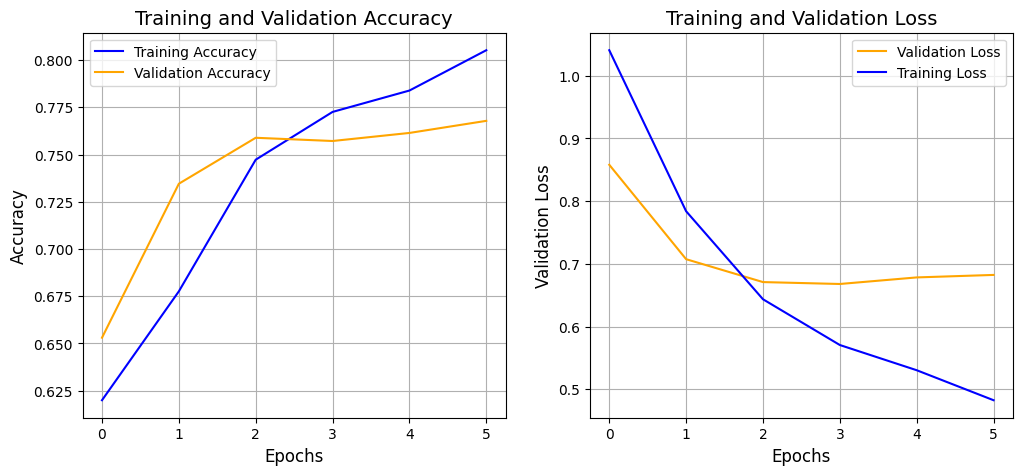

In [147]:
# visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.title("Training and Validation Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.grid(True)